In [13]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from deap import algorithms, base, creator, tools
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin

In [2]:
dataset = pd.read_csv("student_performance/student-mat.csv", sep=';')

In [3]:
def encode_textdata(dataset, list_columns):
    ds = dataset.copy(deep=True)
    ids_list = []
    for column in list_columns:
        ids = {name: id for name, id in zip(list(ds[column].unique()), range(ds.shape[0]))}
        ds[column] = ds[column].transform(lambda x: ids[x])
        ids_list.append(ids)
    return ids_list, ds

In [4]:
ids_list, ds = encode_textdata(dataset, ["address", "famsize", "school", "sex", "Pstatus", "Mjob",
                                          "Fjob", "reason", "guardian", "schoolsup", "famsup", "paid",
                                          "activities", "nursery", "higher", "internet", "romantic"])

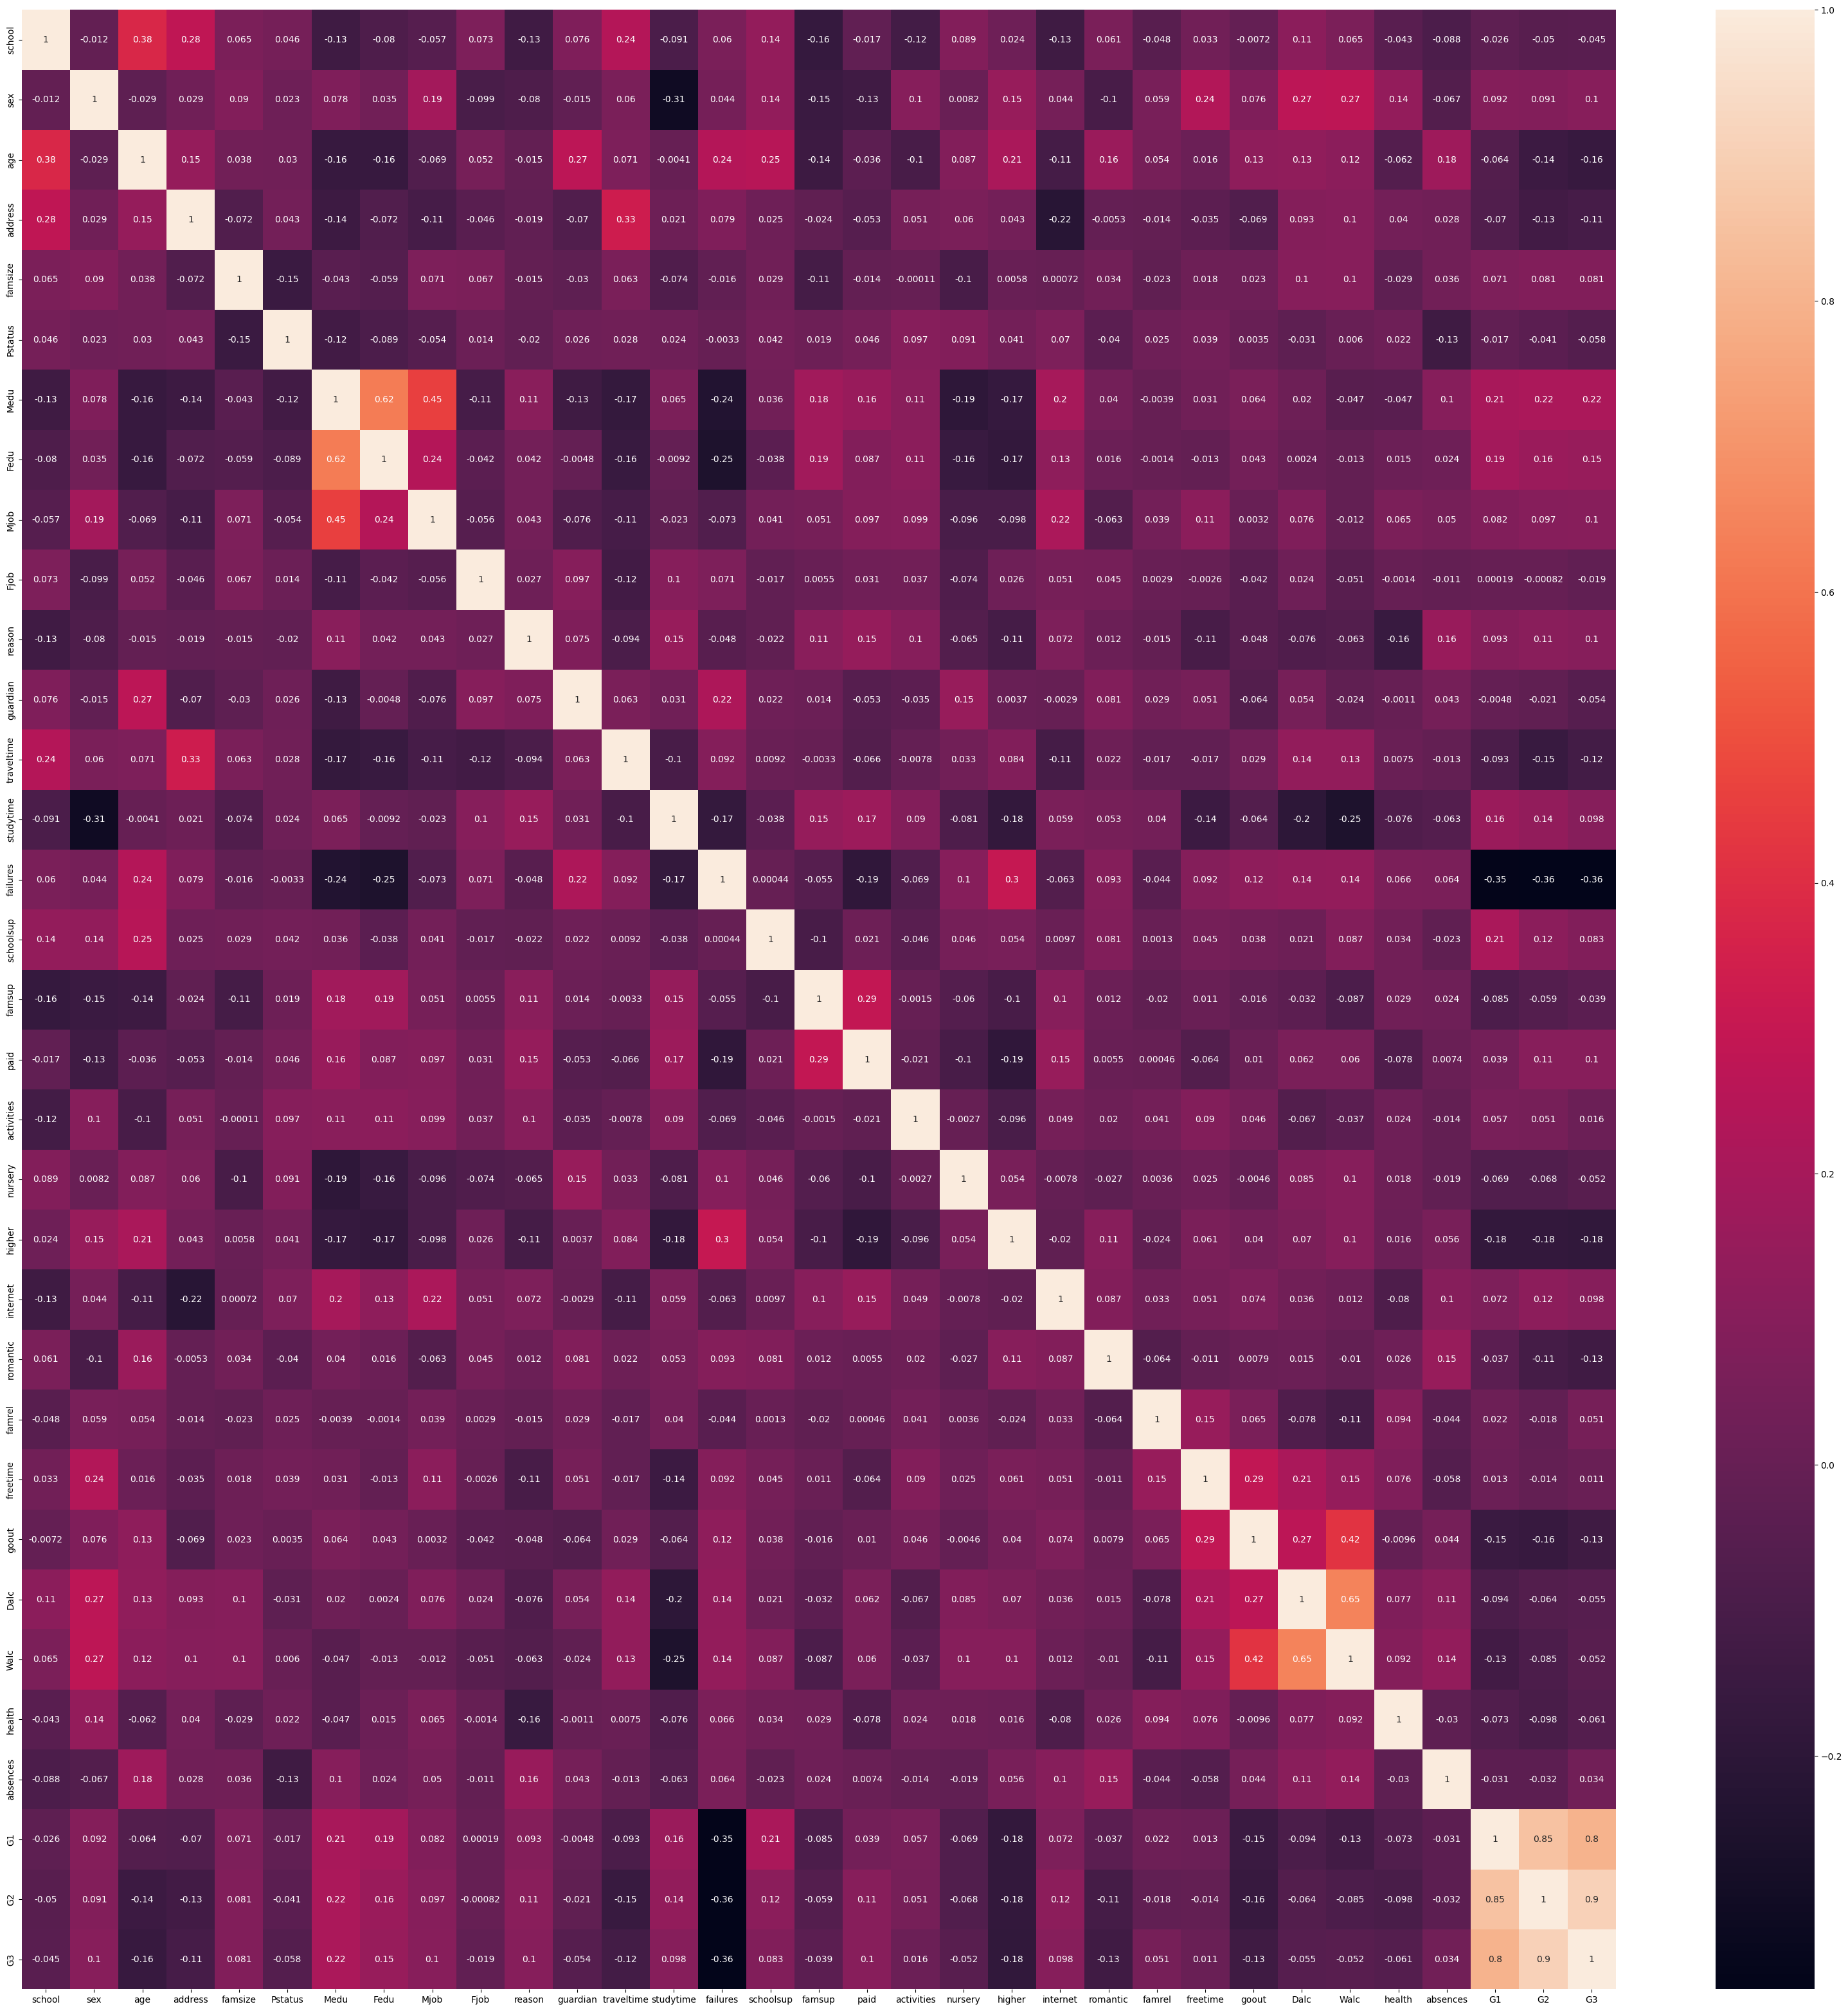

In [5]:
fig, ax = plt.subplots(figsize=(40, 40))
sns.heatmap(ds.corr(), cbar=True, annot=True)

plt.show()

In [5]:
labels = pd.DataFrame()
labels["G3"] = ds["G3"].transform(lambda x: x // 5 if x < 20 else 3)
labels["internet"] = ds["internet"]
X = ds.drop(["G1", "G2", "G3", "internet"], axis=1)

In [6]:
type(labels["internet"][0])

numpy.int64

In [7]:
mm_scaler = MinMaxScaler()
mm_scaler.fit(X)
x = mm_scaler.fit_transform(X)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(x, labels, test_size=0.2, random_state=42)

In [9]:
def evaluate(individual):
    # Decision variables
    G3, internet = individual
    # Train a RF classifier
    rfc = RandomForestClassifier(n_estimators=50)
    #rfc = KNeighborsClassifier()
    rfc.fit(X_train, y_train)
    # Make predictions on the test set
    predictions = rfc.predict(X_test)

    #accuracy = accuracy_score(y_test, predictions)
    accuracy1 = accuracy_score(y_test["G3"], predictions[:, 0])
    accuracy2 = accuracy_score(y_test["internet"], predictions[:, 1])
    
    return (accuracy1 + accuracy2)/2,  # output 2

# Model

In [9]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

In [10]:
toolbox = base.Toolbox()
toolbox.register("attr_int1", np.random.choice, [0, 3])  # Feature 1 range
toolbox.register("attr_int2", np.random.choice, [0, 1])  # Feature 2 range
toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.attr_int1, toolbox.attr_int2), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selBest)

In [11]:
param_grid = {
    'population_size': [30, 50, 70],
    'generations': [15, 30, 45],
}

In [11]:
# Create the population
population = toolbox.population(n=50)

# Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, population))
for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit

In [14]:
generations = 50

# Run the algorithm
algorithms.eaMuPlusLambda(population, toolbox, mu=50, lambda_=100, cxpb=0.7, mutpb=0.2, ngen=generations, stats=None, halloffame=None, verbose=True)

# Get the best individual
best_individual = tools.selBest(population, k=1)[0]

# Print the result
print("Best Individual:", best_individual)
print("Best Accuracy:", best_individual.fitness.values[0])

gen	nevals
0  	0     
1  	87    
2  	93    
3  	85    
4  	94    
5  	96    
6  	89    
7  	87    
8  	90    
9  	91    
10 	88    
11 	89    
12 	94    
13 	85    
14 	91    
15 	90    
16 	92    
17 	95    
18 	90    
19 	90    
20 	98    
21 	87    
22 	87    
23 	91    
24 	85    
25 	96    
26 	91    
27 	94    
28 	94    
29 	93    
30 	93    
31 	90    
32 	92    
33 	92    
34 	87    
35 	89    
36 	93    
37 	93    
38 	91    
39 	84    
40 	91    
41 	93    
42 	92    
43 	91    
44 	80    
45 	89    
46 	93    
47 	85    
48 	86    
49 	91    
50 	90    
Best Individual: [3.4049661247512755, 0.6175905318255379]
Best Accuracy: 0.689873417721519


# Tune

In [15]:
def fit(population_size, generations):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
    toolbox = base.Toolbox()
    toolbox.register("attr_int1", np.random.choice, [0, 3])  # Feature 1 range
    toolbox.register("attr_int2", np.random.choice, [0, 1])  # Feature 2 range
    toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.attr_int1, toolbox.attr_int2), n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
    toolbox.register("select", tools.selBest)
    
    population = toolbox.population(n=population_size)
        
    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit
    
    algorithms.eaMuPlusLambda(population, toolbox, mu=50, lambda_=100, cxpb=0.7, 
                                  mutpb=0.2, ngen=generations, stats=None, halloffame=None, verbose=True)
    
    best_individual = tools.selBest(population, k=1)[0]
    return best_individual

In [14]:
grid_search = GridSearchCV(estimator=tune_parameters, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

InvalidParameterError: The 'estimator' parameter of GridSearchCV must be an object implementing 'fit'. Got <function tune_parameters at 0x00000179055220C0> instead.

In [16]:
best_params = grid_search.bestparams
print("Optimal Parameters:", best_params)

NameError: name 'grid_search' is not defined

# Plot

gen	nevals
0  	0     
1  	90    
Generation 1, Best Accuracy: 0.6708860759493671
gen	nevals
0  	0     
1  	88    
Generation 2, Best Accuracy: 0.6772151898734178
gen	nevals
0  	0     
1  	91    
Generation 3, Best Accuracy: 0.6772151898734178
gen	nevals
0  	0     
1  	96    
Generation 4, Best Accuracy: 0.6772151898734178
gen	nevals
0  	0     
1  	91    
Generation 5, Best Accuracy: 0.6772151898734178
gen	nevals
0  	0     
1  	86    
Generation 6, Best Accuracy: 0.6772151898734178
gen	nevals
0  	0     
1  	87    
Generation 7, Best Accuracy: 0.6772151898734178
gen	nevals
0  	0     
1  	89    
Generation 8, Best Accuracy: 0.6772151898734178
gen	nevals
0  	0     
1  	90    
Generation 9, Best Accuracy: 0.6772151898734178
gen	nevals
0  	0     
1  	88    
Generation 10, Best Accuracy: 0.6835443037974683
gen	nevals
0  	0     
1  	89    
Generation 11, Best Accuracy: 0.6835443037974683
gen	nevals
0  	0     
1  	83    
Generation 12, Best Accuracy: 0.6835443037974683
gen	nevals
0  	0     
1  

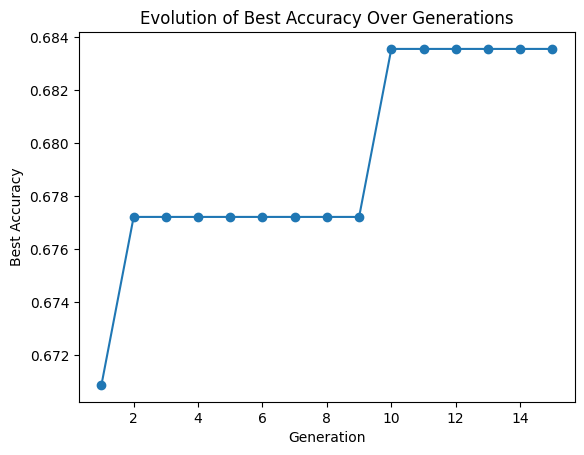

In [12]:
gen_numbers = []
best_accuracies = []
generations = 15

for gen in range(generations):
    algorithms.eaMuPlusLambda(population, toolbox, mu=50, lambda_=100, cxpb=0.7, ngen=1,
                            mutpb=0.2, stats=None, halloffame=None, verbose=True)
    # Get the best individual
    best_individual = tools.selBest(population, k=1)[0]
    
    # Print the best accuracy in the population
    best_fitness = best_individual.fitness.values[0]
    print(f"Generation {gen + 1}, Best Accuracy: {best_fitness}")
    
    # Store data for plotting
    gen_numbers.append(gen + 1)
    best_accuracies.append(best_fitness)

plt.plot(gen_numbers, best_accuracies, marker='o')
plt.title('Evolution of Best Accuracy Over Generations')
plt.xlabel('Generation')
plt.ylabel('Best Accuracy')
plt.show()